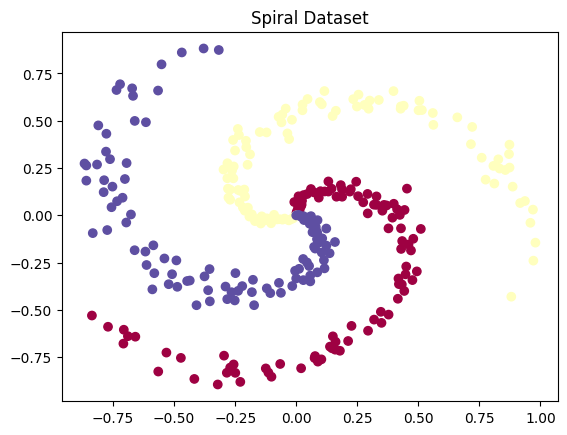

In [2]:
#Linear classifier : beginning. We will then extend to NN.


import numpy as np
import matplotlib.pyplot() as plt


# Number of samples : N
# Number of classes : only possible outcomes of an input (can be the dimension of an image ...) 
# Ex : cat, dog, turtle. K = 3
# Number of features : what we are interested in a single data. 
# Ex : age, weight, job, country. D = 4


# Training input : N*D
# Training output : N*K (f(weightT*X + b))
# Weights W : D*K
# Bias b : 1*K
# The product in NN doesn't work like the traditional one.


def generate_spiral_data(N, K, D):
    X = np.zeros((N * K, D))  # Input data
    y = np.zeros((N * K, K))  # One-hot encoded labels
    for j in range(K):
        ix = range(N * j, N * (j + 1))  # Indices for class j
        r = np.linspace(0.0, 1, N)  # Radius
        t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # Angle with noise
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]  # Polar to Cartesian
        y[ix, j] = 1  # One-hot encode class j
    return X, y

N = 100  # Number of samples per class
K = 3    # Number of classes
D = 2    # Number of features (e.g., 2D data for visualization)

# Generate data
training_inputs, training_outputs = generate_spiral_data(N, K, D)

# Visualize the data
plt.scatter(training_inputs[:, 0], training_inputs[:, 1], c=np.argmax(training_outputs, axis=1), cmap=plt.cm.Spectral)
plt.title("Spiral Dataset")
plt.show()


Iteration 0, Loss: 0.9340203438710138
Iteration 10, Loss: 0.7276910322915571
Iteration 20, Loss: 0.7150128045407456
Iteration 30, Loss: 0.7123149630047164
Iteration 40, Loss: 0.711552173484301
Iteration 50, Loss: 0.711309869038468
Iteration 60, Loss: 0.711228328860472
Iteration 70, Loss: 0.7112000190612083
Iteration 80, Loss: 0.7111900150689373
Iteration 90, Loss: 0.7111864434865595


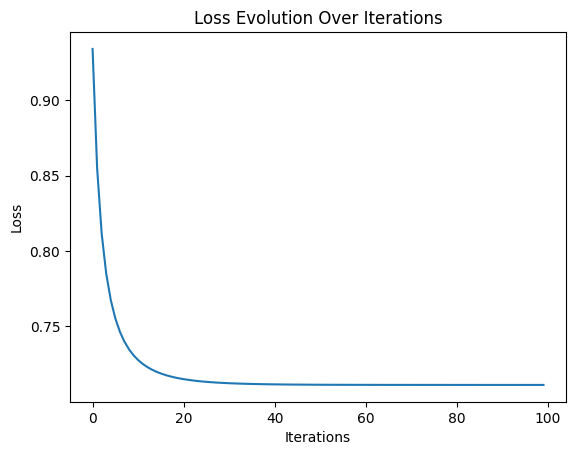

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def generate_spiral_data(N, K, D):
    X = np.zeros((N * K, D))  
    y = np.zeros((N * K, K)) 
    for j in range(K):
        ix = range(N * j, N * (j + 1))  
        r = np.linspace(0.0, 1, N)  
        t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)] 
        y[ix, j] = 1  
    return X, y


N = 100  
K = 3    
D = 2    


training_inputs, training_outputs = generate_spiral_data(N, K, D)
weights = 0.01 * np.random.randn(D,K)
bias = np.zeros((1,K))
calculated_outputs = np.dot(training_inputs, weights) + bias
 

# Beginning of the Forward pass : goal is to get a vector of error on the data


# Softmax_activation : transform the output in raw probabilities
# Will be easier to calculate the loss later
# x is a np.array
# allows to have a vector of probabilities
# Since we want probabilities, we want to have a max of 0 in each row before applying exp and sum


def softmax_activation(inputs):
    first_array = inputs - np.max(inputs, axis=1, keepdims=True)
    exponential_array = np.exp(first_array)
    sum_of_elements = np.sum(exponential_array, axis=1, keepdims=True)
    return exponential_array / sum_of_elements

generated_outputs = softmax_activation(calculated_outputs)


# Second phase of the forward pass : calculate the loss to get the true error
# L = -(1/N)*sum(i:1toN)*sum(k:1toK)*y(i,k)*logŷ(i,k) where y:true and ŷ:predicted
# Préserve les dim input --> output car log appliqué à toute la matrice


def cross_entropy_loss(y_pred, y_true):
    log_prediction = np.log(y_pred)
    element_wise = -y_true*log_prediction
    loss = np.sum(element_wise)
    return loss / y_true.shape[0]
    

error = cross_entropy_loss(generated_outputs, training_outputs)

# Beginning of the Backpropagation

# Je ne détaille pas les calculs de gradients ici : ils sont admis (chain rule)
# dL/dW = XT(ŷ-y)
# dL/db = 1T(ŷ-y)

dZ = generated_outputs - training_outputs
dW = np.dot(training_inputs.T, dZ) / N
db = np.sum(dZ, axis=0, keepdims=True) / N

iterations = 100
learning_rate = 2
weights += -learning_rate * dW
bias += -learning_rate * db 


losses = []

for i in range(iterations):
    calculated_outputs = np.dot(training_inputs, weights) + bias
    generated_outputs = softmax_activation(calculated_outputs)
    loss = cross_entropy_loss(generated_outputs, training_outputs)
    losses.append(loss) 
    
    # Backpropagation
    dZ = generated_outputs - training_outputs
    dW = np.dot(training_inputs.T, dZ) / N
    db = np.sum(dZ, axis=0, keepdims=True) / N
    
    # Update weights and biases
    weights -= learning_rate * dW
    bias -= learning_rate * db
    
    # Print loss every 10 iterations
    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss}")


plt.plot(range(iterations), losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Evolution Over Iterations")
plt.show()


In [8]:
# We notice that despite the number of iterations getting higher, the loss function
# Doesn't approach 0. It is because the linear classifier inadequate for this dataset. 
# We now work with a two-layer NN.

import numpy as np
import matplotlib.pyplot as plt

N = 100  # Number of samples
D = 2    # Number of features
K = 3    # Number of classes (we'll have the probabilities of them at the end)
h1 = 100  # Size of the first hidden layer
h2 = 50   # Size of the second hidden layer
step_size = 2 
regularization_term = 1e-3        

# Generate random spiral data
def generate_spiral_data(N, K, D):
    X = np.zeros((N * K, D))
    y = np.zeros(N * K, dtype='uint8')  # Integer labels for the loss computation
    for j in range(K):
        ix = range(N * j, N * (j + 1))
        r = np.linspace(0.0, 1, N)  # Radius
        t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # Theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j
    return X, y


# Initialize data
X, y = generate_spiral_data(N, K, D)
num_examples = X.shape[0]

# Initialize parameters for two hidden layers and one output layer
W1 = 0.01 * np.random.randn(D, h1)
b1 = np.zeros((1, h1))
W2 = 0.01 * np.random.randn(h1, h2)
b2 = np.zeros((1, h2))
W3 = 0.01 * np.random.randn(h2, K)
b3 = np.zeros((1, K))

# Training loop
for i in range(10000):

    # Forward pass
    hidden_layer1 = np.maximum(0, np.dot(X, W1) + b1)  # ReLU activation
    hidden_layer2 = np.maximum(0, np.dot(hidden_layer1, W2) + b2)  # ReLU activation
    scores = np.dot(hidden_layer2, W3) + b3

    # Softmax activation (output probabilities)
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))  
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Loss calculation
    correct_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(correct_logprobs) / num_examples
    reg_loss = (
        0.5 * regularization_term * np.sum(W1 * W1) +
        0.5 * regularization_term * np.sum(W2 * W2) +
        0.5 * regularization_term * np.sum(W3 * W3) )
    
    loss = data_loss + reg_loss

    if i % 1000 == 0:
        print(f"Iteration {i}: Loss = {loss:.4f}")

    # Backpropagation
    # Gradient on scores

    dscores = probs
    dscores[range(num_examples), y] -= 1
    dscores /= num_examples

    # Gradients for W3 and b3
    dW3 = np.dot(hidden_layer2.T, dscores) + regularization_term * W3
    db3 = np.sum(dscores, axis=0, keepdims=True)

    # Gradients for hidden layer 2
    dhidden2 = np.dot(dscores, W3.T)
    dhidden2[hidden_layer2 <= 0] = 0  # Backprop through ReLU

    # Gradients for W2 and b2
    dW2 = np.dot(hidden_layer1.T, dhidden2) + regularization_term * W2
    db2 = np.sum(dhidden2, axis=0, keepdims=True)

    # Gradients for hidden layer 1
    dhidden1 = np.dot(dhidden2, W2.T)
    dhidden1[hidden_layer1 <= 0] = 0  # Backprop through ReLU

    # Gradients for W1 and b1
    dW1 = np.dot(X.T, dhidden1) + regularization_term * W1
    db1 = np.sum(dhidden1, axis=0, keepdims=True)

    # Parameters updates
    W1 -= step_size * dW1
    b1 -= step_size * db1
    W2 -= step_size * dW2
    b2 -= step_size * db2
    W3 -= step_size * dW3
    b3 -= step_size * db3

# Final training loss
print(f"Final Loss = {loss:.4f}")


Iteration 0: Loss = 1.0989
Iteration 1000: Loss = 0.3485
Iteration 2000: Loss = 1.1129
Iteration 3000: Loss = 1.0989
Iteration 4000: Loss = 1.0986
Iteration 5000: Loss = 1.0986
Iteration 6000: Loss = 1.0986
Iteration 7000: Loss = 1.0986
Iteration 8000: Loss = 1.0986
Iteration 9000: Loss = 1.0986
Final Loss = 1.0986
